In [1]:
from downtime import load_dataset
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import classification_report
#from MARS import MARS
import numpy as np

import sys
sys.path.insert(0,'..')
from MARS.MARS import MARS

# Getting the data

In [2]:
d = load_dataset("SelfRegulationSCP1")

X_train = d.X_train
X_test = d.X_test
y_train = d.y_train
y_test = d.y_test

In [3]:
print(d)

X_train: (268, 6, 896)
X_test: (293, 6, 896)
y_train: (268,)
y_test: (293,)
Metadata:
{'labels': {'0': 'negativity', '1': 'positivity'},
 'name': 'SelfRegulationSCP1',
 'task': 'classification'}


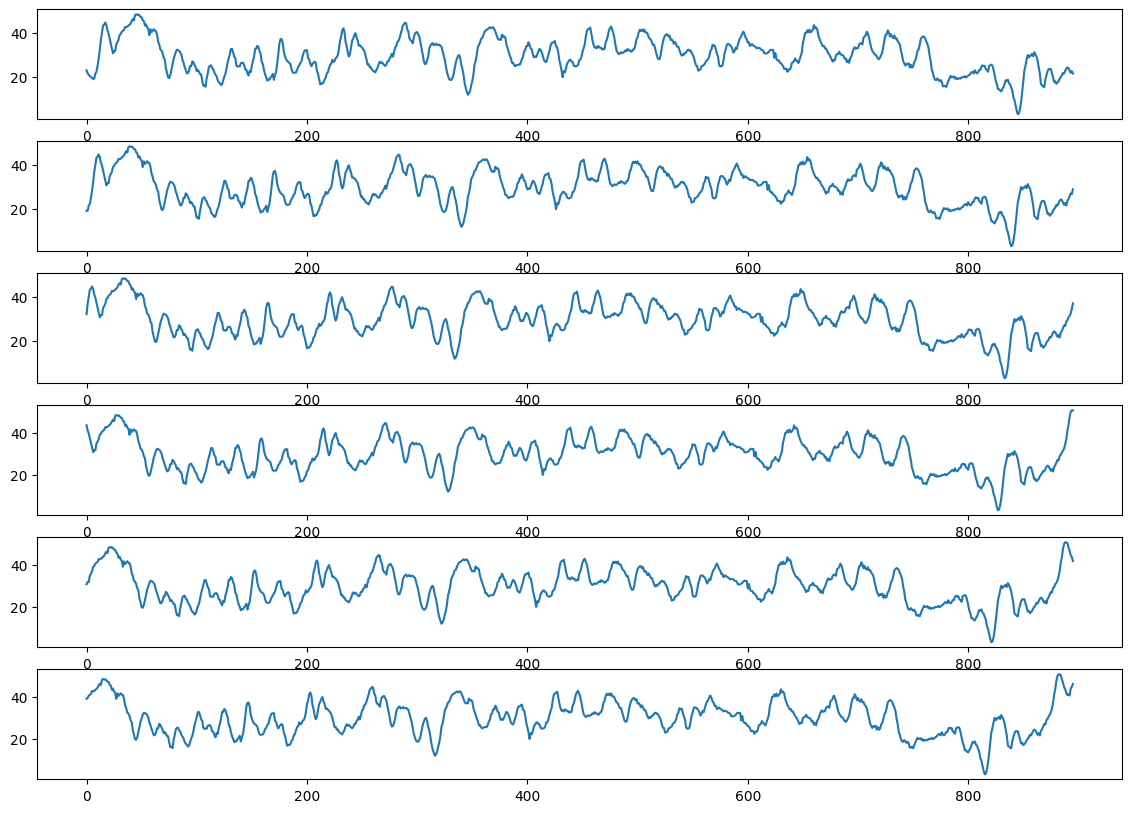

In [4]:
plt.figure(figsize=(14,10))

for i,dim in enumerate(d.X_train[0]):
    plt.subplot(6,1,i+1)
    plt.plot(dim)

# Multivariate Asynchronous Random Shapelets

In [58]:
import numpy as np
from scipy.spatial.distance import euclidean
from sklearn.metrics import pairwise_distances
import random

In [65]:
def get_shapelets(time_series, shapelet_length, num_permutations, same_start=False, seed=None):
    if seed is not None:
        random.seed(seed)

    #num_time_series = len(time_series)
    num_dimensions = len(time_series[0])
    max_window_length = len(time_series[0][0])  # Use the length of the first time series and first dimension

    if shapelet_length > max_window_length:
        raise ValueError("Shapelet length is greater than the length of the time series dimensions. "
                         "Please specify a valid shapelet length.")

    sliding_windows = []

    for _ in range(num_permutations):
        shapelet = []

        for dim_idx in range(num_dimensions):
            window_length = shapelet_length
            if not same_start:
                window_indices = random.randint(0, max_window_length - window_length)
            else:
                window_indices = 0
            window = [ts[dim_idx][window_indices:window_indices + window_length] for ts in time_series]
            shapelet.append(window)

        sliding_windows.append(shapelet)

    return sliding_windows


In [66]:
shapelets = get_shapelets(X_train, shapelet_length=20, num_permutations=5, same_start=False, seed=42)

In [61]:
print(len(shapelets))
print(len(shapelets[0]))
print(len(shapelets[0][0]))

5
6
268


In [63]:
shapelets

[[[<Array [41.2, 40.3, 41.6, 40.3, ..., 33, 32.9, 31.8, 30.7] type='20 * float64'>,
   <Array [35.7, 36.2, 36.7, 36.6, ..., 36.6, 34, 31.5, 31.4] type='20 * float64'>,
   <Array [32, 31.6, 31.1, 30.3, ..., 39.2, 38.2, 39.7, 40.7] type='20 * float64'>,
   <Array [36.9, 34.5, 33.2, 32, ..., 48, 46.7, 45, 44.9] type='20 * float64'>,
   <Array [15.1, 15.7, 16.9, 17.5, ..., 27.5, 27.5, 27.1] type='20 * float64'>,
   <Array [38.1, 40.5, 41.3, 40.2, ..., 34.8, 36, 37.9, 39.3] type='20 * float64'>,
   <Array [43.7, 44, 44.1, 43.1, ..., 50.8, 49.5, 48.9, 48.3] type='20 * float64'>,
   <Array [37.1, 37.6, 38.2, 38.9, ..., 26.8, 26.3, 26.2] type='20 * float64'>,
   <Array [7.97, 8.91, 8.12, 8.16, ..., -0.19, -0.62, -1.66] type='20 * float64'>,
   <Array [26.1, 24.4, 20, 21.7, ..., 27.4, 28.1, 28.8, 31.3] type='20 * float64'>,
   <Array [81.9, 82.8, 83.9, 86.2, ..., 98.2, 97.7, 97.6] type='20 * float64'>,
   <Array [41.2, 41.1, 40.2, 37, ..., 23.3, 22.5, 23.5, 23.4] type='20 * float64'>,
   <Array

In [71]:
import numpy as np

def calculate_shapelet_distance(shapelet, time_series):
    min_distance = float('inf')

    # Iterate through each window in the shapelet
    for shapelet_window, time_series_window in zip(shapelet, time_series):
        total_distance = 0.0

        # Calculate the distance for each dimension and sum them up
        for dim in range(len(shapelet_window)):
            dimension_distance = np.linalg.norm(shapelet_window[dim] - time_series_window[dim])
            total_distance += dimension_distance

        # Update the minimum distance if needed
        if total_distance < min_distance:
            min_distance = total_distance

    return min_distance

def get_distances(shapelets, time_series_dataset):
    distances = []

    # Iterate through each time series in the dataset
    for time_series in time_series_dataset:
        distances_to_shapelets = []

        # Calculate the minimum distance to each shapelet for the current time series
        for shapelet in shapelets:
            min_distance = calculate_shapelet_distance(shapelet, time_series)
            distances_to_shapelets.append(min_distance)

        distances.append(distances_to_shapelets)

    return distances


In [72]:
# Example usage:
# Calculate distances from shapelets to your dataset of time series
distances = get_distances(shapelets, X_train)

# 'distances' now contains a list of lists where each inner list represents the distances from each shapelet to a time series.

In [73]:
distances

[[21638.096803284196,
  21970.35644287873,
  21145.96755999061,
  21073.514404602556,
  22635.407722739255],
 [21717.188493221867,
  23471.154478704404,
  22640.190620312296,
  22194.667937200164,
  24639.072613959317],
 [21962.106741553023,
  24369.413907505823,
  23652.11920253374,
  24518.743520427237,
  25405.145442136858],
 [21955.540843833507,
  21504.694308118684,
  22751.128159620534,
  22543.78830795195,
  21815.42641711046],
 [23496.892769927552,
  22980.423510030363,
  23524.045464223953,
  22769.24880062619,
  22949.407562801705],
 [24136.42434540932,
  24943.61112789342,
  23721.262656224695,
  24169.797389054565,
  26324.99675048667],
 [26045.035233586423,
  32705.22210099151,
  32068.708710461884,
  32210.385816080627,
  33565.808175767495],
 [21592.925471065682,
  21744.9918296253,
  21118.2745959092,
  21624.040057807448,
  22722.040209893443],
 [33308.33549245658,
  32801.6496017758,
  35001.517280237924,
  35225.5978998999,
  33117.28960054659],
 [23683.621049664114,

In [76]:
print(len(distances))
print(len(distances[0]))


268
5


# Classification

In [77]:
X_train_transformed = distances

In [78]:
clf = lgb.LGBMClassifier()
clf.fit(X_train_transformed, y_train)

LGBMClassifier()

## Training set

In [82]:
y_pred_train = clf.predict(X_train_transformed)

In [83]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       135
           1       0.93      0.89      0.91       133

    accuracy                           0.91       268
   macro avg       0.91      0.91      0.91       268
weighted avg       0.91      0.91      0.91       268



## Test set

In [84]:
X_test_transformed = get_distances(shapelets, X_test)


In [85]:
y_pred_test = clf.predict(X_test_transformed)

In [87]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.68      0.59      0.63       147
           1       0.63      0.73      0.68       146

    accuracy                           0.66       293
   macro avg       0.66      0.66      0.65       293
weighted avg       0.66      0.66      0.65       293

